## Initialization

In [1]:
%%capture
!pip install pydot
!apt install graphviz -y

In [2]:
%%capture
!pip install git+https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git

In [3]:
import tensorflow as tf
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output
import tensorflow_advanced_segmentation_models as tasm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}

2023-05-20 19:00:37.667853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
DATA_DIR = "/data/camera_lidar_semantic/"

In [5]:
COMBINED_CLASSES = {'road': [32, 40, 44, 42, 50, 27, 40, 42, 44, 50], \
                    'car': [0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 23, 24, 46], \
                    'pedestrian': [4, 5, 6, 7, 8, 9, 10], \
                    'road signs/signals': [17, 18, 19, 20, 21, 22], \
                    'lanes': [28, 47, 48, 49]}

## Model Definition

In [6]:
models_info = [
    {
        "BACKBONE_NAME": "efficientnetb0", #val_iou_score: 0.6 	224x224
        "WEIGHTS": "imagenet",
        "HEIGHT": 224+16,
        "WIDTH": 224+16,
        "MODEL_CHECKPOINT_PATH": os.path.join(DATA_DIR, "efficientnetb0" + ".ckpt"),
        "load": True
    },
    {
        "BACKBONE_NAME": "efficientnetb4",
        "WEIGHTS": "imagenet",
        "HEIGHT": 380+20,
        "WIDTH": 380+20,
        "MODEL_CHECKPOINT_PATH": os.path.join(DATA_DIR, "efficientnetb4" + ".ckpt"),
        "load": True
    },
]

OUTPUT_CLASSES = len(COMBINED_CLASSES.items()) + 1

## Helper functions

In [7]:
def hex2rgb(hex_id):
    hex_id = hex_id[1:]
    return tuple(int(hex_id[i:i+2], 16) for i in (0, 2, 4))

def get_classes_to_ids(json_file=os.path.join(DATA_DIR, "camera_lidar_semantic", "class_list.json")):
    with open(json_file) as file:
        hex_dict = json.load(file)
        file.close()

    class_dict = {}
    rgb_dict = {}
    inverse_rgb_dict = {}

    j = 0
    for key in list(hex_dict.keys()):
        class_dict[j] = hex_dict[key]
        rgb_dict[hex2rgb(key)] = j
        inverse_rgb_dict[j] = hex2rgb(key)
        j += 1
    
    return class_dict, rgb_dict
class_dict, color_map = get_classes_to_ids()

In [8]:
%%capture
def create_static_hash_table(dictionary):
    keys = []
    values = []
    
    for key, value in dictionary.items():
        hash_key = key[0] * 1000000 + key[1] * 1000 + key[2]
        keys.append(hash_key)
        values.append(value)
    
    keys_tensor = tf.constant(keys, dtype=tf.int32)
    values_tensor = tf.constant(values, dtype=tf.int32)
    
    hash_table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor),
        default_value=0
    )
    
    return hash_table

tfDict = create_static_hash_table(color_map)

2023-05-20 19:00:39.898434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 19:00:39.906799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 19:00:39.907051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 19:00:39.909619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-20 19:00:39.909841: I tensorflow/compile

In [9]:
@tf.function
def convert_tensor(tensor):
    shape = tf.shape(tensor)
    batch_size = shape[:-1]
    values = tf.reshape(tensor, (-1, 3))
    converted_values = values[:, 0] * 1000000 + values[:, 1] * 1000 + values[:, 2]
    converted_tensor = tf.reshape(converted_values, tf.concat([batch_size, [1]], axis=0))
    return converted_tensor

In [10]:
def create_static_hash_table_for_Combined_classes(dictionary):
    keys = []
    values = []
    temp_dict = {}

    i = 0
    for key, value in dictionary.items():
        for val in value:
            keys.append(val)
            if (key in temp_dict):
                values.append(temp_dict[key])
            else:
                temp_dict[key] = i
                i = i+1
                values.append(temp_dict[key])
    
    keys_tensor = tf.constant(keys, dtype=tf.int32)
    values_tensor = tf.constant(values, dtype=tf.int32)
    
    hash_table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor),
        default_value=i
    )
    
    return hash_table

tfDict_Combined = create_static_hash_table_for_Combined_classes(COMBINED_CLASSES)

In [11]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [45]:
def show_predictions():
  for sample_image, sample_mask in models_info[0]["train_batches"].skip(random.randint(0, 15)).take(1):
    predicted = models_info[0]["model"].predict(sample_image[0][tf.newaxis, ...])
    print(predicted.shape)
    display([sample_image[0], sample_mask[0],
             create_mask(predicted)])

In [13]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [14]:
# Define the preprocessing function
def preprocess_for_EfficientNet(image, label):
    # Rescale the pixel values to [0-255] range
    rescaled_image = image * 255.0
    
    # Preprocess the image tensor
    preprocessed_image = tf.keras.applications.efficientnet_v2.preprocess_input(rescaled_image)
    
    return preprocessed_image, label


## Data Initialization

In [15]:
def get_dataset(model_info):
    
    def load_image(img_path):
        # Read image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, (model_info["WIDTH"], model_info["HEIGHT"]))
        return img

    def load_label(label_path):
        # Read label
        label = tf.io.read_file(label_path)
        label = tf.image.decode_png(label, channels=3)
        label = tf.image.convert_image_dtype(label, tf.uint8)
        label = tf.cast(label, tf.int32)
        label = tf.image.resize(
            label,
            (model_info["WIDTH"], model_info["HEIGHT"]),
            method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
        )
        label = tfDict.lookup(convert_tensor(label))
        label = tfDict_Combined.lookup(label)
        return label

    # Define the generator function
    def data_generator(image_paths, label_paths):
        for image_path, label_path in zip(image_paths, label_paths):
            image = load_image(image_path)
            label = load_label(label_path)
            yield image, label

    image_paths_train = glob.glob(os.path.join(os.path.join(DATA_DIR, "camera_lidar_semantic/*/camera/cam_front_center"), '*.png')) 
    label_paths_train = glob.glob(os.path.join(os.path.join(DATA_DIR, "camera_lidar_semantic/*/label/cam_front_center"), '*.png')) 
    image_paths_val = glob.glob(os.path.join(os.path.join(DATA_DIR, "camera_lidar_semantic_val/*/camera/cam_front_center"), '*.png')) 
    label_paths_val = glob.glob(os.path.join(os.path.join(DATA_DIR, "camera_lidar_semantic_val/*/label/cam_front_center"), '*.png')) 
    image_paths_test = glob.glob(os.path.join(os.path.join(DATA_DIR, "camera_lidar_semantic_test/*/camera/cam_front_center"), '*.png')) 
    label_paths_test = glob.glob(os.path.join(os.path.join(DATA_DIR, "camera_lidar_semantic_test/*/label/cam_front_center"), '*.png')) 

    # Create TensorFlow datasets using the generator function
    train_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=(image_paths_train, label_paths_train),
        output_signature=(        
            tf.TensorSpec(shape=(model_info["WIDTH"], model_info["HEIGHT"], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(model_info["WIDTH"], model_info["HEIGHT"], 1), dtype=tf.int32))
    )

    val_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=(image_paths_val, label_paths_val),
        output_signature=(        
            tf.TensorSpec(shape=(model_info["WIDTH"], model_info["HEIGHT"], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(model_info["WIDTH"], model_info["HEIGHT"], 1), dtype=tf.int32))
    )

    test_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=(image_paths_test, label_paths_test),
        output_signature=(        
            tf.TensorSpec(shape=(model_info["WIDTH"], model_info["HEIGHT"], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(model_info["WIDTH"], model_info["HEIGHT"], 1), dtype=tf.int32))
    )
    return train_dataset.map(preprocess_for_EfficientNet), val_dataset.map(preprocess_for_EfficientNet), test_dataset.map(preprocess_for_EfficientNet)

for model_info in models_info:
    model_info["train_dataset"], model_info["val_dataset"], model_info["test_dataset"] = get_dataset(model_info)

In [16]:
for model_info in models_info:
    BATCH_SIZE = 1
    BUFFER_SIZE = 10
    model_info["train_batches"] = (
        model_info["train_dataset"]
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

    model_info["val_batches"] = model_info["val_dataset"].batch(BATCH_SIZE)
    model_info["test_batches"] = model_info["test_dataset"].batch(1)

In [17]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

2023-05-20 19:00:43.455967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


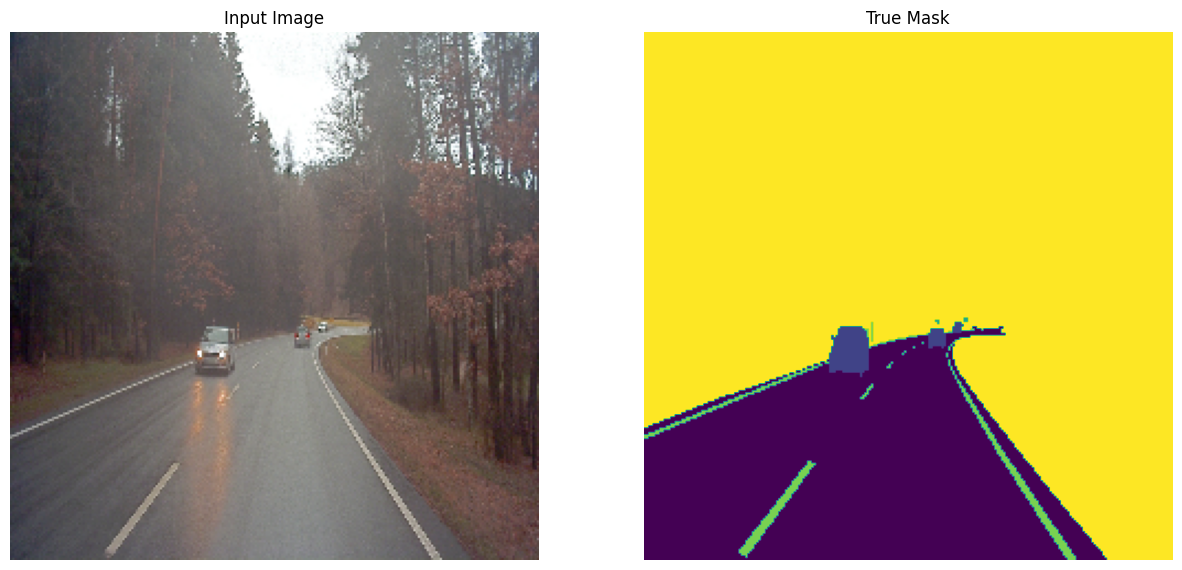

In [18]:
for images, masks in models_info[0]["val_dataset"].take(1): # take one batch from the dataset
    sample_image, sample_mask = images, masks # take the first image and mask from the batch
    display([sample_image, sample_mask])

## Model initialization

### Functions from tasm library, changed to support Sparse Labels

In [19]:
import tensorflow.keras.backend as K

class KerasObject:
    def __init__(self, name=None):
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            return self.__class__.__name__
        return self._name

    @property
    def name(self):
        return self.__name__

    @name.setter
    def name(self, name):
        self._name = name

class Metric(KerasObject):
    pass

class Loss(KerasObject):

    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError('Loss should be inherited from `Loss` class')

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError('Loss should be inherited from `BaseLoss` class')

    def __rmul__(self, other):
        return self.__mul__(other)

class MultipliedLoss(Loss):

    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split('+')) > 1:
            name = '{}({})'.format(multiplier, loss.__name__)
        else:
            name = '{}{}'.format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, gt, pr):
        return self.multiplier * self.loss(gt, pr)


class SumOfLosses(Loss):

    def __init__(self, l1, l2):
        name = '{}_plus_{}'.format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, gt, pr):
        return self.l1(gt, pr) + self.l2(gt, pr)

def average(x, class_weights=None):
    if class_weights is not None:
        x = x * class_weights
    return K.mean(x)

def gather_channels(*xs):
    return xs

def round_if_needed(x, threshold):
    if threshold is not None:
        x = K.greater(x, threshold)
        x = K.cast(x, K.floatx())
    return x
def iou_score(y_true, y_pred, class_weights=1., smooth=1e-5, threshold=None):    
    y_true = K.one_hot(K.squeeze(K.cast(y_true, tf.int32), axis=-1), OUTPUT_CLASSES)

    y_true, y_pred = gather_channels(y_true, y_pred)
    y_pred = round_if_needed(y_pred, threshold)
    axes = [1, 2] if K.image_data_format() == "channels_last" else [2, 3]
    
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, class_weights)

    return score

class IOUScore(Metric):
    def __init__(self, class_weights=None, threshold=None, smooth=1e-5, name=None):
        name = name or "iou_score"
        super().__init__(name=name)
        self.class_weights = class_weights if class_weights is not None else 1.
        self.threshold = threshold
        self.smooth = smooth

    def __call__(self, y_true, y_pred):
        return iou_score(
            y_true,
            y_pred,
            class_weights=self.class_weights,
            smooth=self.smooth,
            threshold=self.threshold
        )
    
class Sparse_Metric():
    def __init__(self, metric):
        self.metric = metric

    def __call__(self, y_true, y_pred):
        y_true = K.one_hot(K.squeeze(K.cast(y_true, tf.int32), axis=-1), OUTPUT_CLASSES)
        return self.metric(
            y_true,
            y_pred
        )
    
def dice_coefficient(y_true, y_pred, beta=1.0, class_weights=1., smooth=1e-5, threshold=None):
    # print(y_pred)
    y_true = K.one_hot(K.squeeze(K.cast(y_true, tf.int32), axis=-1), OUTPUT_CLASSES)
    y_true, y_pred = gather_channels(y_true, y_pred)
    y_pred = round_if_needed(y_pred, threshold)
    axes = [1, 2] if K.image_data_format() == "channels_last" else [2, 3]
    
    tp = K.sum(y_true * y_pred, axis=axes)
    fp = K.sum(y_pred, axis=axes) - tp
    fn = K.sum(y_true, axis=axes) - tp

    score = ((1.0 + beta) * tp + smooth) / ((1.0 + beta) * tp + (beta ** 2.0) * fn + fp + smooth)
    # print("Score, wo avg: " + str(score))
    score = average(score, class_weights)
    # print("Score: " + str(score))

    return score

class DiceLoss(Loss):
    def __init__(self, beta=1.0, class_weights=None, smooth=1e-5):
        super().__init__(name="dice_loss")
        self.beta = beta
        self.class_weights = class_weights if class_weights is not None else 1.0
        self.smooth = smooth

    def __call__(self, y_true, y_pred):
        # print(y_pred)
        return 1.0 - dice_coefficient(
            y_true,
            y_pred,
            beta=self.beta,
            class_weights=self.class_weights,
            smooth=self.smooth,
            threshold=None
        )
    
def categorical_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true, y_pred = gather_channels(y_true, y_pred)
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    loss = - y_true * (alpha * K.pow((1 - y_pred), gamma) * K.log(y_pred))

    return K.mean(loss)
    
class CategoricalFocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(name="focal_loss")
        self.alpha = alpha
        self.gamma = gamma

    def __call__(self, y_true, y_pred):
        return categorical_focal_loss(
            y_true,
            y_pred,
            alpha=self.alpha,
            gamma=self.gamma
        )


### Model loading

In [20]:
def load_model(model_info, load_weights=False):
    base_model, layers, layer_names = tasm.create_base_model(name=model_info["BACKBONE_NAME"], weights=model_info["WEIGHTS"], height=model_info["HEIGHT"], width=model_info["WIDTH"])
    model = tasm.DANet(n_classes=OUTPUT_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=False)
    model.compile(tf.keras.optimizers.Adam(0.0001), loss=DiceLoss()+CategoricalFocalLoss(), metrics=[IOUScore(threshold=0.5)])
    if load_weights:
        model.load_weights(model_info["MODEL_CHECKPOINT_PATH"])
    # Freeze layers for fine-tuning
    for layer in model.layers:
        if "functional" in layer.name:
            layer.trainable = False
    return model

for model_info in models_info:
    model_info["model"] = load_model(model_info, model_info["load"])

2023-05-20 19:42:50.453924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [27257]
	 [[{{node Placeholder/_2}}]]
2023-05-20 19:42:50.454261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [27257]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 0s 16ms/step
(1, 240, 240, 6)


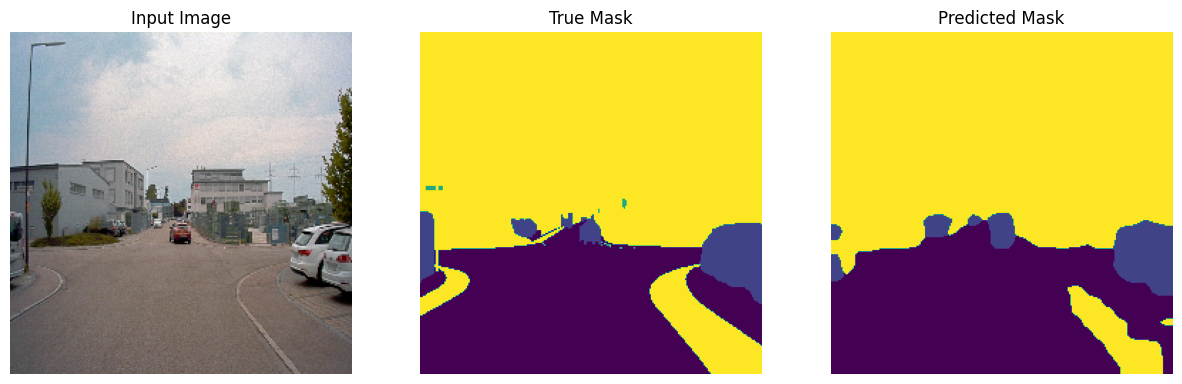

In [63]:
show_predictions()

In [22]:
def get_callbacks(model_info):
    return [
                tf.keras.callbacks.ModelCheckpoint(model_info["MODEL_CHECKPOINT_PATH"], verbose=1, save_weights_only=True, save_best_only=True),
                tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
    ]

In [23]:
for model_info in models_info:
    print("Starting to train model ", model_info["BACKBONE_NAME"])
    model_info["history"] = model_info["model"].fit(
        model_info["train_batches"],
        epochs=75,
        validation_data=model_info["val_batches"],
        validation_steps=20,
        steps_per_epoch=200,
        callbacks=get_callbacks(model_info),
    )

Starting to train model  efficientnetb0
Epoch 1/75
Epoch 1: val_loss improved from inf to 1.57378, saving model to /data/camera_lidar_semantic/efficientnetb0.ckpt
200/200 [==============================] - 28s 104ms/step - loss: 1.1990 - iou_score: 0.0156 - val_loss: 1.5738 - val_iou_score: 0.0216
Epoch 2/75
200/200 [==============================] - ETA: 0s - loss: 1.1361 - iou_score: 0.0271
Epoch 2: val_loss improved from 1.57378 to 1.36212, saving model to /data/camera_lidar_semantic/efficientnetb0.ckpt
200/200 [==============================] - 20s 98ms/step - loss: 1.1361 - iou_score: 0.0271 - val_loss: 1.3621 - val_iou_score: 0.0115
Epoch 3/75
200/200 [==============================] - ETA: 0s - loss: 1.0559 - iou_score: 0.0242
Epoch 3: val_loss did not improve from 1.36212
200/200 [==============================] - 19s 94ms/step - loss: 1.0559 - iou_score: 0.0242 - val_loss: 1.4001 - val_iou_score: 0.0118
Epoch 4/75
200/200 [==============================] - ETA: 0s - loss: 0.95

Starting to train model  efficientnetb4
Epoch 1/75
200/200 [==============================] - ETA: 0s - loss: 1.1647 - iou_score: 0.0069
Epoch 1: val_loss improved from inf to 1.54045, saving model to /data/camera_lidar_semantic/efficientnetb4.ckpt
200/200 [==============================] - 32s 108ms/step - loss: 1.1647 - iou_score: 0.0069 - val_loss: 1.5404 - val_iou_score: 0.0020
Epoch 2/75
200/200 [==============================] - ETA: 0s - loss: 1.1487 - iou_score: 0.0187
Epoch 2: val_loss improved from 1.54045 to 1.46979, saving model to /data/camera_lidar_semantic/efficientnetb4.ckpt
200/200 [==============================] - 20s 101ms/step - loss: 1.1487 - iou_score: 0.0187 - val_loss: 1.4698 - val_iou_score: 0.0335
Epoch 3/75
200/200 [==============================] - ETA: 0s - loss: 1.0658 - iou_score: 0.0148
Epoch 3: val_loss improved from 1.46979 to 1.46124, saving model to /data/camera_lidar_semantic/efficientnetb4.ckpt
200/200 [==============================] - 20s 99ms/s

History of model efficientnetb0


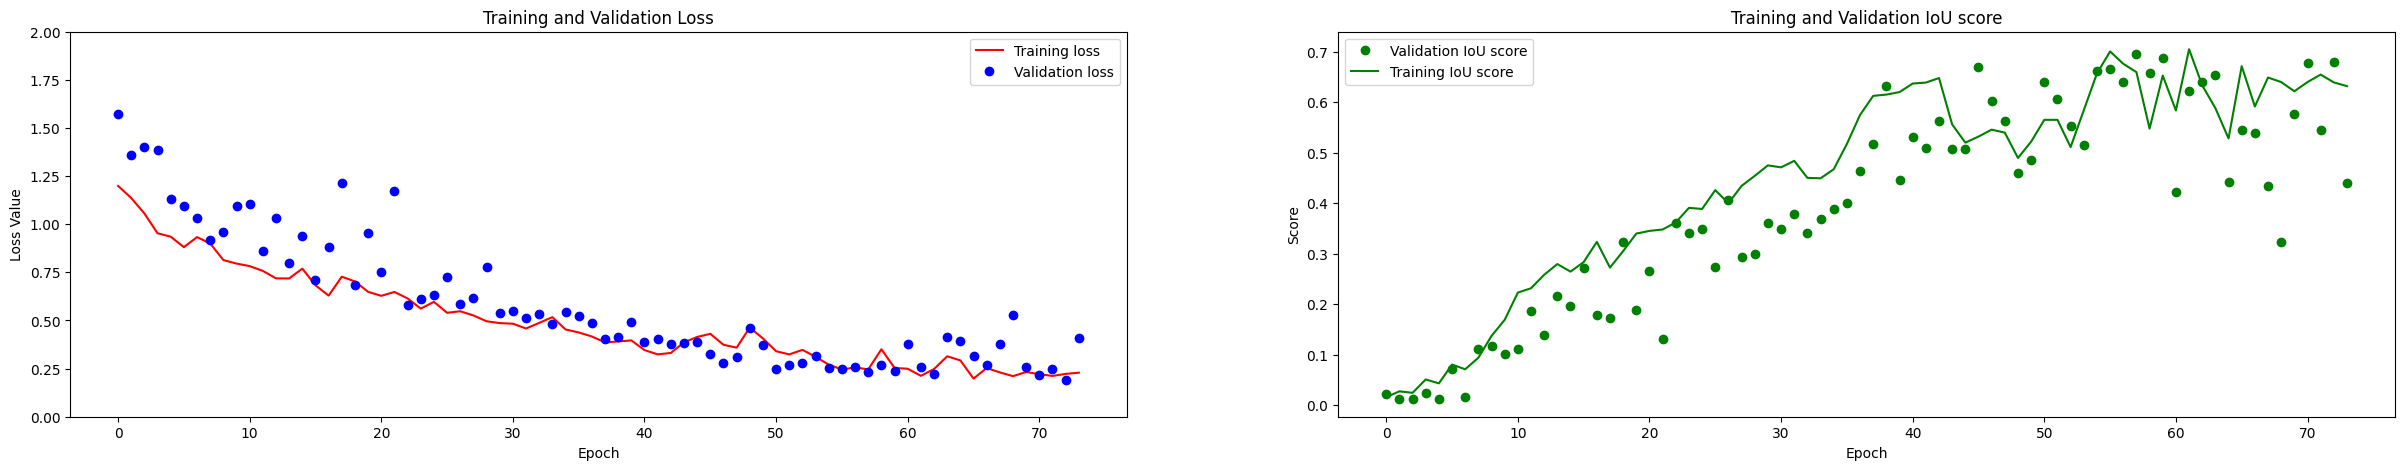

History of model efficientnetb4


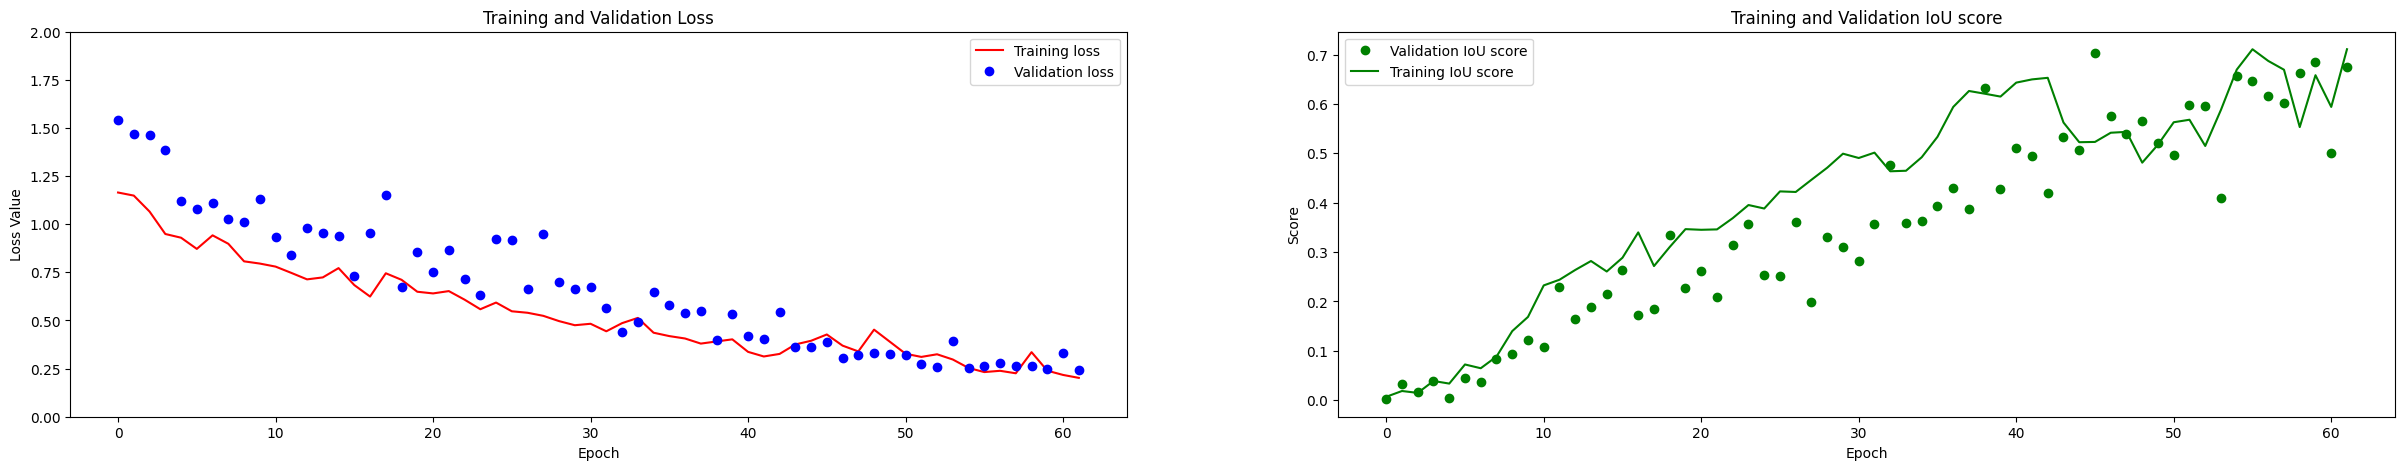

In [24]:
for model_info in models_info:
    print("History of model", model_info["BACKBONE_NAME"])
    loss = model_info["history"].history['loss']
    val_loss = model_info["history"].history['val_loss']
    val_iou_score = model_info["history"].history['val_iou_score']
    iou_score_h = model_info["history"].history['iou_score']

    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(model_info["history"].epoch, loss, 'r', label='Training loss')
    plt.plot(model_info["history"].epoch, val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 2])
    plt.legend()
    plt.subplot(122)
    plt.title('Training and Validation IoU score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.plot(model_info["history"].epoch, val_iou_score, 'go', label='Validation IoU score')
    plt.plot(model_info["history"].epoch, iou_score_h, 'g', label='Training IoU score')
    plt.legend()
    plt.show()

# Test

In [27]:
for model_info in models_info:
    SMALL_MODEL = "b0" in model_info["BACKBONE_NAME"]
    SMALL_RESOLUTION = models_info[0]["WIDTH"]
    FULL_RESOLUTION = models_info[1]["WIDTH"]
    TEST_BATCHES = models_info[1]["test_batches"]

    total_samples = 0
    total_metric = [0.0, 0.0, 0.0]
    total_time = 0.0

    iou_metric = Sparse_Metric(tasm.metrics.IOUScore(threshold=0.5))
    iou_2_metric = tf.keras.metrics.MeanIoU(OUTPUT_CLASSES, sparse_y_pred = False)
    dice_metric = Sparse_Metric(tasm.metrics.FScore())

    # Iterate over the test dataset
    for data, labels in TEST_BATCHES.take(200):
        # Make predictions using the loaded model
        if (SMALL_MODEL):
            resized_image = tf.image.resize(data, [SMALL_RESOLUTION, SMALL_RESOLUTION])
            start_time = time.time()
            predictions = model_info["model"].predict(resized_image, verbose=0)
            predictions = tf.image.resize(predictions, [FULL_RESOLUTION, FULL_RESOLUTION], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            elapsed_time = time.time() - start_time
        else:
            start_time = time.time()
            predictions = model_info["model"].predict(data, verbose=0)
            elapsed_time = time.time() - start_time
    
        # Calculate the metric for the current batch
        iou_r = iou_metric(labels, predictions)
        iou_2_r = iou_2_metric(labels, predictions)
        dice_r = dice_metric(labels, predictions)
        
        # Update the total metric and sample count
        total_metric[0] += iou_r * len(data)
        total_metric[1] += iou_2_r * len(data)
        total_metric[2] += dice_r * len(data)
        total_samples += len(data)
        total_time += elapsed_time

    # Calculate the average metric
    average_metric = np.array(total_metric) / total_samples

    # Print the average metric
    print('results for ', model_info["BACKBONE_NAME"])
    print('Average IoU, Dice:', average_metric[0], average_metric[2])
    print('average time for single prediction:', total_time/total_samples)

2023-05-20 19:08:30.755543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


results for  efficientnetb0
Average IoU, Dice: 0.59213394 0.3400127
average time for single prediction: 0.05184395313262939


2023-05-20 19:08:48.443660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


results for  efficientnetb4
Average IoU, Dice: 0.631714 0.3528983
average time for single prediction: 0.06404061317443847
